# Introdução à Ciência de Dados - Projeto Parte 1

<p align="justify">
Nesse proejto iremos realizar uma análise de dados sobre um dataset de carros usados da cidade de Recife - PE. O dataset foi montado a partir de dados coletados por webscraping de diversos sites de vendas. O dataset contém informações sobre o preço, ano, quilometragem, marca, modelo, tipo de combustível, tipo de câmbio e cor dos veículos. O objetivo desse projeto é realizar uma análise exploratória dos dados, respondendo a algumas perguntas sobre o dataset e gerando visualizações que possam ajudar a entender melhor o dataset.

### Equipe:
> Pedro Henrique Almeida Girão Peixinho (phagp)

> Victor Gabriel de Carvalho (vgc3)

### Tópicos Avançados em Gerenciamento de Dados e Informação IF697 - 2024.1 - Centro de Informáica UFPE

## Imports e Configurações

<p align="justify">
Nessa seção especifiaremos as bibliotecas necessárias no decorrer do projeto, e lidarermos com o carregamento do dataset.


In [1]:
! pip install -U kaleido
! pip install fancyimpute

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
# pio.kaleido.scope.default_format = "svg"
pio.renderers.default = "svg"

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

from fancyimpute import KNN

from scipy.stats import shapiro, ttest_rel, mannwhitneyu

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Para rodar o crawler, primeiro esteja na pasta inicial do projeto e ative o venv:
```
venv\Scripts\activate
```
Com o ambiente virtual ativado, instale as bibliotecas necessárias:
```
pip install -r requirements.txt
```
Agora, mude para o diretório do crawler e rode o arquivo base:
```
cd .\carscraper\
python main.py
```
As amostras obditas estarão no arquivo `cars.csv`.


<p align="justify">
Aqui está o dataset montado, ele é composto por 1124 amostras com 12 features cada:

- page: URL da página de onde foi tirada a amostra.
- car_brand: Marca do veículo.
- car_name: Nome do veículo
- car_price: Preço do carro no momento da coleta.
- car_km: Quilometragem total do carro.
- car_year: Ano do modelo.
- car_desc: Descrição e informações gerais do veíclulo.
- car_store: Loja onde o carro está localizado.
- car_engine: Tamanho/Tipo do motor.
- car_gearbox: Tipo de embreagem.
- car_fuel: Tipo de combustível.
- car_color: Cor do automível.

<p align="justify">
Vale ressaltar que, natualmente, nem todos os campos puderam ser preenchidos para todas as amostras. Esse e outros problemas serão tratados nesse colab.

In [3]:
df_cars = pd.read_csv('/content/drive/MyDrive/Tópicos Avançados em Gerenciamento de Dados e Informação/TGD - Projeto 1/cars.csv')
df_cars.shape

(1124, 12)

---

## Pré-processamento dos Dados

<p align="justify">
Nessa etapa, será feita a leitura do dataset e a análise inicial dos dados. Mais precisamente, focaremos na definição e correção de tipos de dados, tratamento de valores faltantes, mormalização e discretização de dados, e limpeza geral.

<p align="justify">
Abaixo está a aparência inicial do dataset, após a leitura dos dados. Veja que algumas colunas não apresentam valores estatísticos significantes para a análise, como a coluna de "page" e a de "car_desc" (que ja teve seus valores diluídos entre outras colunas, como a "car_engine" e "car_gearbox"). Elas serão removidas do dataset.

In [4]:
df_cars.head()

,page,car_brand,car_name,car_price,car_km,car_year,car_desc,car_store,car_engine,car_gearbox,car_fuel,car_color
0,https://grupoautonunes.com/estoque/?zero_km=0&...,Fiat,500E,125990.0,7521.0,2022,ICON ELÉTRICO,NaN,Elétrico,Automatico,Elétrico,NaN
1,https://grupoautonunes.com/estoque/?zero_km=0&...,Audi,Q3,128980.0,40000.0,2018,1.4 TFSI AMBIENTE FLEX 4P S TRONIC,NaN,1.4,Automatico,Flex,NaN
2,https://grupoautonunes.com/estoque/?zero_km=0&...,Chevrolet,Onix,70990.0,40686.0,2023,1.0 FLEX LT MANUAL,NaN,1.0,Manual,Flex,NaN
3,https://grupoautonunes.com/estoque/?zero_km=0&...,Chevrolet,Onix,79990.0,57643.0,2022,1.0 TURBO FLEX PLUS LTZ AUTOMÁTICO,NaN,1.0 Turbo,Automatico,Flex,NaN
4,https://grupoautonunes.com/estoque/?zero_km=0&...,Volkswagen,Saveiro,77990.0,29000.0,2023,1.6 MSI TRENDLINE CS 8V FLEX 2P MANUAL,NaN,1.6,Manual,Flex,NaN


<p align="justify">
Além das colunas irrelevantes, será feita a remoção de linhas duplicadas, caso existam.

In [5]:
df_cars.drop(['page', 'car_desc'], axis=1, inplace=True)
df_cars.drop_duplicates(inplace=True)

df_cars.head()

,car_brand,car_name,car_price,car_km,car_year,car_store,car_engine,car_gearbox,car_fuel,car_color
0,Fiat,500E,125990.0,7521.0,2022,NaN,Elétrico,Automatico,Elétrico,NaN
1,Audi,Q3,128980.0,40000.0,2018,NaN,1.4,Automatico,Flex,NaN
2,Chevrolet,Onix,70990.0,40686.0,2023,NaN,1.0,Manual,Flex,NaN
3,Chevrolet,Onix,79990.0,57643.0,2022,NaN,1.0 Turbo,Automatico,Flex,NaN
4,Volkswagen,Saveiro,77990.0,29000.0,2023,NaN,1.6,Manual,Flex,NaN


<p align="justify">
Agora podemos fazer uma primeira análise dos dados numéricos do dataset.

In [6]:
df_cars.describe()

,car_price,car_km,car_year
count,1103.000000,1103.000000,1103.000000
mean,107248.161378,45323.883953,2020.113327
std,104532.480654,33650.024486,3.032617
min,24990.000000,0.000000,2000.000000
25%,59900.000000,25113.500000,2019.000000
50%,76990.000000,43339.000000,2021.000000
75%,109900.000000,61505.000000,2022.000000
max,968900.000000,654000.000000,2025.000000


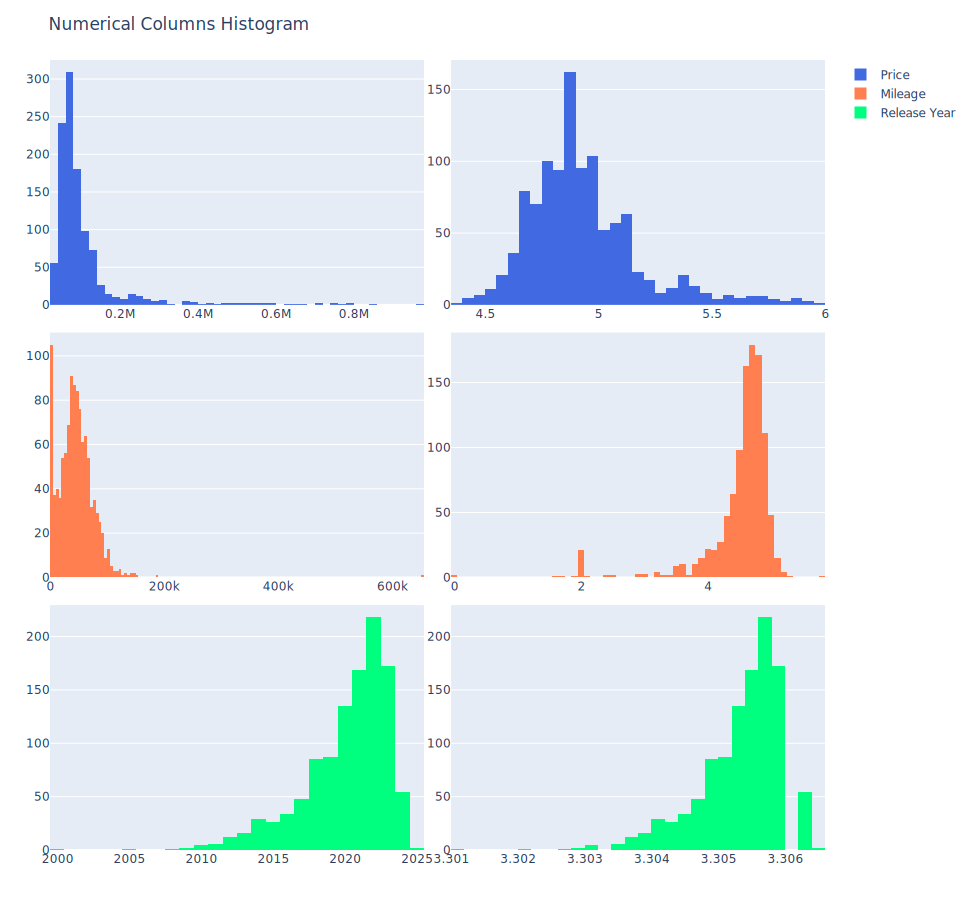

In [7]:
fig = make_subplots(rows=3, cols=2, vertical_spacing=0.035, horizontal_spacing=0.035)

fig.append_trace(go.Histogram(x=df_cars['car_price'], name='Price', marker_color='royalblue'), row=1, col=1)
fig.append_trace(go.Histogram(x=df_cars['car_price'].apply(np.log10), name='Price', marker_color='royalblue', showlegend=False), row=1, col=2)

fig.append_trace(go.Histogram(x=df_cars['car_km'], name='Mileage', marker_color='coral'), row=2, col=1)
fig.append_trace(go.Histogram(x=df_cars['car_km'].apply(np.log10), name='Mileage', marker_color='coral', showlegend=False), row=2, col=2)

fig.append_trace(go.Histogram(x=df_cars['car_year'], name='Release Year', marker_color='springgreen'), row=3, col=1)
fig.append_trace(go.Histogram(x=df_cars['car_year'].apply(np.log10), name='Release Year', marker_color='springgreen', showlegend=False), row=3, col=2)

fig.update_layout(height=900, width=970, title_text="Numerical Columns Histogram",
                  margin=dict(l=50, r=50, t=60, b=50))
fig.show()

---

### Definição de Tipos

<p align="justify">
Agora iremos fazer o tratamento dos tipos de dados do dataset. Isso é importante para carantir a correture das operações estatísticas e visualizações que iremos realizar sobre os dados. Apesar do crawler ter feito um bom trabalho em relação aos tipos de dados, ainda existem algumas colunas que precisam ser ajustadas.

In [8]:
df_cars.dtypes

car_brand       object
car_name        object
car_price      float64
car_km         float64
car_year         int64
car_store       object
car_engine      object
car_gearbox     object
car_fuel        object
car_color       object
dtype: object

<p align="justify">
A primeira coisa a ser é mudar o tipo de dados de "object" para "category", para as colunas que representam categorias. Isso é importante para facilitar a manipulação desses dados e possibilitar uma série de operações nativas do pandas.

In [9]:
df_cars_cat = df_cars.copy()

df_cars_cat['car_brand'] = df_cars['car_brand'].astype('category')
df_cars_cat['car_name'] = df_cars['car_name'].astype('category')
df_cars_cat['car_engine'] = df_cars['car_engine'].astype('category')
df_cars_cat['car_gearbox'] = df_cars['car_gearbox'].astype('category')
df_cars_cat['car_fuel'] = df_cars['car_fuel'].astype('category')
df_cars_cat['car_color'] = df_cars['car_color'].astype('category')
df_cars_cat['car_store'] = df_cars['car_store'].astype('category')

df_cars_cat.dtypes

car_brand      category
car_name       category
car_price       float64
car_km          float64
car_year          int64
car_store      category
car_engine     category
car_gearbox    category
car_fuel       category
car_color      category
dtype: object

<p align="justify">
Uma das possibilidades ao se usar o tipo categórico é a visualização de todas as categorias por feature, como é mostrado abaixo.

In [10]:
print(f"Marcas: {list(df_cars_cat['car_brand'].cat.categories)}")
print(f"Nomes: {list(df_cars_cat['car_name'].cat.categories)}")
print(f"Motores: {list(df_cars_cat['car_engine'].cat.categories)}")
print(f"Embreagem: {list(df_cars_cat['car_gearbox'].cat.categories)}")
print(f"Combustível: {list(df_cars_cat['car_fuel'].cat.categories)}")
print(f"Cores: {list(df_cars_cat['car_color'].cat.categories)}")
print(f"Lojas: {list(df_cars_cat['car_store'].cat.categories)}")

Marcas: ['Alfa', 'Audi', 'Bmw', 'Byd', 'Caoa', 'Chery', 'Chevrolet', 'Citroën', 'Fiat', 'Ford', 'Honda', 'Hyundai', 'Jaguar', 'Jeep', 'Kia', 'Land', 'Lexus', 'Mercedes-Benz', 'Mini', 'Mitsubishi', 'Nissan', 'Peugeot', 'Porsche', 'Ram', 'Renault', 'Smart', 'Suzuki', 'Toyota', 'Troller', 'Volkswagen', 'Volvo']
Nomes: ['2008', '207', '208', '3008', '320I', '330I', '3500', '430I', '500', '500E', '718', '911', 'A3', 'A4', 'A5', 'Aircross', 'Amarok', 'Argo', 'Asx', 'Azera', 'C 300', 'C3', 'C4', 'C4 Cactus', 'C40', 'Captur', 'Cayenne', 'Celta', 'Chery Tiggo 2', 'City', 'Civic', 'Classic', 'Commander', 'Compass', 'Cooper', 'Corolla', 'Corolla Cross', 'Countryman', 'Creta', 'Cronos', 'Crossfox', 'Cruze', 'Crv', 'Doblò', 'Duster', 'Duster Oroch', 'E 400', 'E-Pace ', 'E-Tron', 'Ecosport', 'Equinox', 'Etios', 'Fastback', 'Fiesta', 'Fiorino', 'Fit', 'Fortwo', 'Fox', 'Frontier', 'Fusion', 'Glc 220D', 'Glc 250', 'Glc 43 Amg', 'Gol', 'Grand', 'Grand Siena', 'Hb20', 'Hb20S', 'Hb20X', 'Hilux', 'Hilux Sw

<p align="justify">
Também podemos plotar graficos com a freqência dos atributos categóricos mais importantes. Isso ajudarai a entender melhor nossos dados.

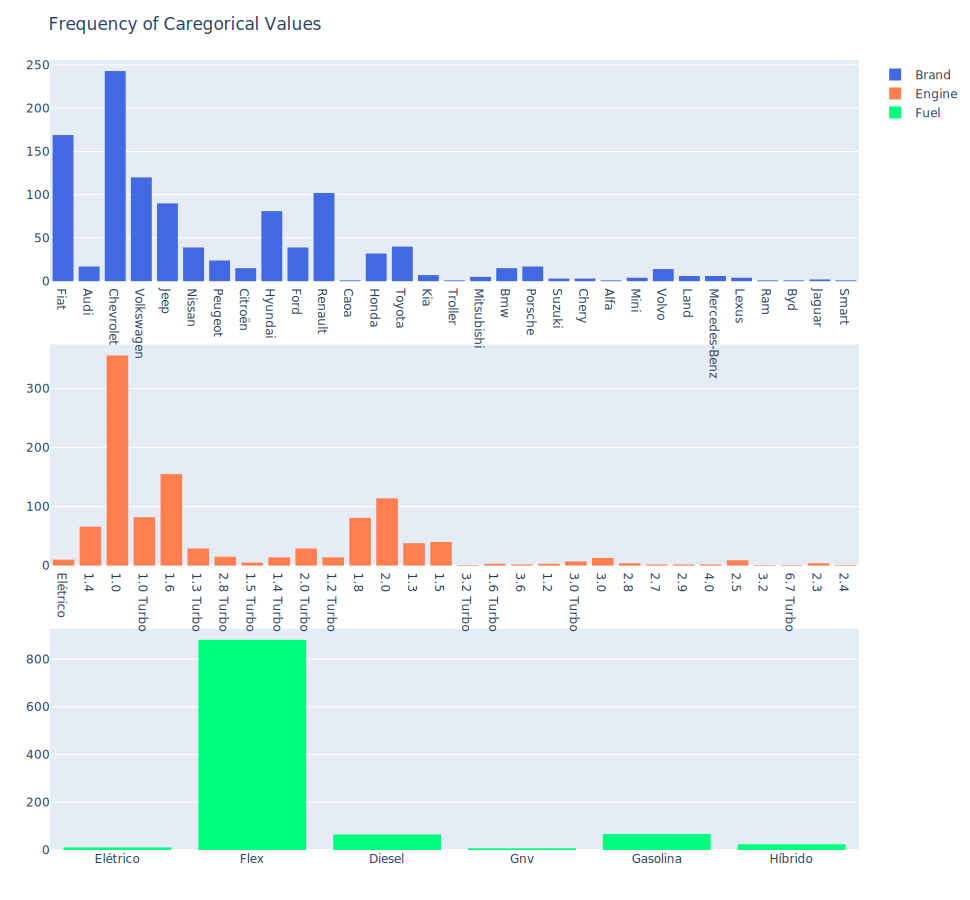

In [11]:
fig = make_subplots(rows=3, cols=1, vertical_spacing=0.08, horizontal_spacing=0.035)

fig.append_trace(go.Histogram(x=df_cars_cat['car_brand'], name='Brand', marker_color='royalblue'), row=1, col=1)
fig.append_trace(go.Histogram(x=df_cars_cat['car_engine'], name='Engine', marker_color='coral'), row=2, col=1)
fig.append_trace(go.Histogram(x=df_cars_cat['car_fuel'], name='Fuel', marker_color='springgreen'), row=3, col=1)

fig.update_layout(height=900, width=970, title_text="Frequency of Caregorical Values",
                  margin=dict(l=50, r=50, t=60, b=50))
fig.show()

---

### Tratamento de Dados Ausentes

<p align="justify">
Com os tipos definidos, podemos agora analisar a presença de valores ausentes no dataset. Isso é importante para garantir a qualidade dos dados e evitar erros em operações estatísticas e visualizações. É muito comum, em datasets feios por webscraping, a presença de valores ausentes, então é importante lidar com eles de forma adequada.

In [12]:
df_cars_cat.isnull().sum()

car_brand         0
car_name          0
car_price         0
car_km            0
car_year          0
car_store      1095
car_engine        0
car_gearbox       0
car_fuel         48
car_color       986
dtype: int64

<p align="justify">
A primeira coisa que faremos é a remoção de colunas com mais de 70% dos valores ausentes. Outros métodos de inferência e adição de valores seria inviável, pois a quantidade de faltas é muito grande.

In [13]:
df_cars_cat.dropna(thresh=0.7*len(df_cars_cat), axis=1, inplace=True)
print(f"Colunas restantes: {list(df_cars_cat.columns)}")

Colunas restantes: ['car_brand', 'car_name', 'car_price', 'car_km', 'car_year', 'car_engine', 'car_gearbox', 'car_fuel']


<p align="justify">
Como era de se esperar, as colunas "car_store" e "car_color" foram removidas. Agora podemos analisar a presença de valores ausentes na coluna "car_fuel", a única que ainda tem valores faltanets.

In [14]:
df_cars_cat.count()

car_brand      1103
car_name       1103
car_price      1103
car_km         1103
car_year       1103
car_engine     1103
car_gearbox    1103
car_fuel       1055
dtype: int64

<p align="justify">
Para fazer os processos de adição de valores faltantes, é importante converter os campos categóricos para um formato numérico. Dessa forma, podemos fazer operações como média, KNN etc.

In [15]:
df_cars_cat.dtypes

car_brand      category
car_name       category
car_price       float64
car_km          float64
car_year          int64
car_engine     category
car_gearbox    category
car_fuel       category
dtype: object

<p align="justify">
A operação cat.codes converte as labels do formato de string para um formato numérico. Note que, no caso de "car_fuel", estamos mantendo os valores nulos como NaN, ja que cat.codes transorma eles em -1.

In [16]:
df_cars_codes = df_cars_cat.copy()

df_cars_codes['car_brand'] = df_cars_cat['car_brand'].cat.codes
df_cars_codes['car_name'] = df_cars_cat['car_name'].cat.codes
df_cars_codes['car_engine'] = df_cars_cat['car_engine'].cat.codes
df_cars_codes['car_gearbox'] = df_cars_cat['car_gearbox'].cat.codes
df_cars_codes['car_fuel'] = df_cars_cat['car_fuel'].cat.codes.replace(-1, np.nan)

print('Brand:', df_cars_codes['car_brand'].mean(), df_cars_codes['car_brand'].median())
print('Name:', df_cars_codes['car_name'].mean(), df_cars_codes['car_brand'].median())
print('Engine:', df_cars_codes['car_engine'].mean(), df_cars_codes['car_engine'].median())
print('Gearbox:', df_cars_codes['car_gearbox'].mean(), df_cars_codes['car_gearbox'].median())
print('Fuel:', df_cars_codes['car_fuel'].mean(), df_cars_codes['car_fuel'].median())

Brand: 14.053490480507707 11.0
Name: 84.84406165004533 11.0
Engine: 6.647325475974615 6.0
Gearbox: 0.45602901178603805 0.0
Fuel: 2.0113744075829385 2.0


In [17]:
df_cars_codes.dtypes

car_brand         int8
car_name         int16
car_price      float64
car_km         float64
car_year         int64
car_engine        int8
car_gearbox       int8
car_fuel       float64
dtype: object

Utilizando Média e Mediana

In [18]:
df_mean_fill = df_cars_codes.copy()

df_mean_fill['car_fuel'] = df_mean_fill['car_fuel'].fillna(df_mean_fill['car_fuel'].mean())
df_mean_fill.isnull().sum()

car_brand      0
car_name       0
car_price      0
car_km         0
car_year       0
car_engine     0
car_gearbox    0
car_fuel       0
dtype: int64

In [19]:
print('Fuel:', df_mean_fill['car_fuel'].mean(), df_mean_fill['car_fuel'].median())

Fuel: 2.011374407582938 2.0


In [20]:
df_median_fill = df_cars_codes.copy()

df_median_fill['car_fuel'] = df_median_fill['car_fuel'].fillna(df_median_fill['car_fuel'].median())
df_median_fill.isnull().sum()

car_brand      0
car_name       0
car_price      0
car_km         0
car_year       0
car_engine     0
car_gearbox    0
car_fuel       0
dtype: int64

In [21]:
print('Fuel:', df_median_fill['car_fuel'].mean(), df_median_fill['car_fuel'].median())

Fuel: 2.0108794197642794 2.0


<p align="justify">
Em uma primeira análise, não parece ser o ideal adicionar dados cateóricos baseados na média ou mediana de dados categóricos, ja que, geralmete, o valor inferido pela média não se encaixa em nenhuma categoria e não faz sentido algum tipo de ordenação para fazer a mediana. O trecho abaixo infere novos valores de acordo com o algoritmo KNN, fazendo mais sentido em nossa abordagem.

In [22]:
df_knn = KNN(k=5).fit_transform(df_cars_codes)
df_knn.shape

Imputing row 1/1103 with 0 missing, elapsed time: 0.336
Imputing row 101/1103 with 0 missing, elapsed time: 0.337
Imputing row 201/1103 with 0 missing, elapsed time: 0.338
Imputing row 301/1103 with 1 missing, elapsed time: 0.340
Imputing row 401/1103 with 0 missing, elapsed time: 0.341
Imputing row 501/1103 with 0 missing, elapsed time: 0.342
Imputing row 601/1103 with 0 missing, elapsed time: 0.343
Imputing row 701/1103 with 0 missing, elapsed time: 0.344
Imputing row 801/1103 with 0 missing, elapsed time: 0.345
Imputing row 901/1103 with 0 missing, elapsed time: 0.346
Imputing row 1001/1103 with 0 missing, elapsed time: 0.347
Imputing row 1101/1103 with 0 missing, elapsed time: 0.348


(1103, 8)

In [23]:
df_knn_fill = pd.DataFrame(data=df_knn[0:,0:], columns=[df_cars_codes.columns])

df_knn_fill.head()

,car_brand,car_name,car_price,car_km,car_year,car_engine,car_gearbox,car_fuel
0,8.0,9.0,125990.0,7521.0,2022.0,29.0,0.0,1.0
1,1.0,108.0,128980.0,40000.0,2018.0,6.0,0.0,2.0
2,6.0,96.0,70990.0,40686.0,2023.0,0.0,1.0,2.0
3,6.0,96.0,79990.0,57643.0,2022.0,1.0,0.0,2.0
4,29.0,122.0,77990.0,29000.0,2023.0,10.0,1.0,2.0


In [24]:
df_knn_fill.isnull().sum()

car_brand      0
car_name       0
car_price      0
car_km         0
car_year       0
car_engine     0
car_gearbox    0
car_fuel       0
dtype: int64

In [25]:
print('Fuel:', df_knn_fill['car_fuel'].mean().item(), df_knn_fill['car_fuel'].median().item())

Fuel: 2.012580139908748 2.0


In [26]:
df_knn_fill.describe()

,car_brand,car_name,car_price,car_km,car_year,car_engine,car_gearbox,car_fuel
count,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000
mean,14.053490,84.844062,107248.161378,45323.883953,2020.113327,6.647325,0.456029,2.012580
std,8.661922,40.197304,104532.480654,33650.024486,3.032617,6.548008,0.498289,0.727666
min,0.000000,0.000000,24990.000000,0.000000,2000.000000,0.000000,0.000000,0.000000
25%,6.000000,54.000000,59900.000000,25113.500000,2019.000000,0.000000,0.000000,2.000000
50%,11.000000,91.000000,76990.000000,43339.000000,2021.000000,6.000000,0.000000,2.000000
75%,24.000000,113.000000,109900.000000,61505.000000,2022.000000,12.000000,1.000000,2.000000
max,30.000000,157.000000,968900.000000,654000.000000,2025.000000,29.000000,1.000000,5.000000


<p align="justify">
A partir de agora, usaremos o dataset preenchido com o KNN como o dataset principal, para as anlaíses posteriores.

---

### Normalização e Discretização

<p align="justify">
O próximo passo é fazer a normalização dos dados numéricos do dataset. A normalização é importante para garantir que as features tenham a mesma escala, evitando que features com valores maiores dominem o resultado das operações. Utilizaremos tano o método de normalização Min-Max quanto o método de normalização padrão (removendo a média e escalando para variância unitária), ambos da biblioteca scikit-learn.

In [27]:
df_knn_fill.head()

,car_brand,car_name,car_price,car_km,car_year,car_engine,car_gearbox,car_fuel
0,8.0,9.0,125990.0,7521.0,2022.0,29.0,0.0,1.0
1,1.0,108.0,128980.0,40000.0,2018.0,6.0,0.0,2.0
2,6.0,96.0,70990.0,40686.0,2023.0,0.0,1.0,2.0
3,6.0,96.0,79990.0,57643.0,2022.0,1.0,0.0,2.0
4,29.0,122.0,77990.0,29000.0,2023.0,10.0,1.0,2.0


In [28]:
min_max_scaler = MinMaxScaler()
df_knn_fill_norm = min_max_scaler.fit_transform(df_knn_fill)
df_knn_fill_norm = pd.DataFrame(df_knn_fill_norm, columns=df_knn_fill.columns)
df_knn_fill_norm.head()

,car_brand,car_name,car_price,car_km,car_year,car_engine,car_gearbox,car_fuel
0,0.266667,0.057325,0.107002,0.011500,0.88,1.000000,0.0,0.2
1,0.033333,0.687898,0.110169,0.061162,0.72,0.206897,0.0,0.4
2,0.200000,0.611465,0.048733,0.062211,0.92,0.000000,1.0,0.4
3,0.200000,0.611465,0.058268,0.088139,0.88,0.034483,0.0,0.4
4,0.966667,0.777070,0.056149,0.044343,0.92,0.344828,1.0,0.4


In [29]:
standard_scaler = StandardScaler()
df_knn_fill_std = standard_scaler.fit_transform(df_knn_fill)
df_knn_fill_std = pd.DataFrame(df_knn_fill_std, columns=df_knn_fill.columns)
df_knn_fill_std.head()

,car_brand,car_name,car_price,car_km,car_year,car_engine,car_gearbox,car_fuel
0,-0.699179,-1.887651,0.179373,-1.123923,0.622409,3.415208,-0.915605,-1.392176
1,-1.507681,0.576318,0.207990,-0.158285,-0.697182,-0.098903,-0.915605,-0.017296
2,-0.930180,0.277655,-0.347018,-0.137890,0.952307,-1.015628,1.092173,-0.017296
3,-0.930180,0.277655,-0.260881,0.366261,0.622409,-0.862841,-0.915605,-0.017296
4,1.726325,0.924758,-0.280022,-0.485328,0.952307,0.512247,1.092173,-0.017296


In [30]:
robust_scaler = RobustScaler()
df_knn_fill_rob = robust_scaler.fit_transform(df_knn_fill)
df_knn_fill_rob = pd.DataFrame(df_knn_fill_rob, columns=df_knn_fill.columns)
df_knn_fill_rob.head()

,car_brand,car_name,car_price,car_km,car_year,car_engine,car_gearbox,car_fuel
0,-0.166667,-1.389831,0.9800,-0.984241,0.333333,1.916667,0.0,-1.0
1,-0.555556,0.288136,1.0398,-0.091752,-1.000000,0.000000,0.0,0.0
2,-0.277778,0.084746,-0.1200,-0.072902,0.666667,-0.500000,1.0,0.0
3,-0.277778,0.084746,0.0600,0.393059,0.333333,-0.416667,0.0,0.0
4,1.000000,0.525424,0.0200,-0.394021,0.666667,0.333333,1.0,0.0


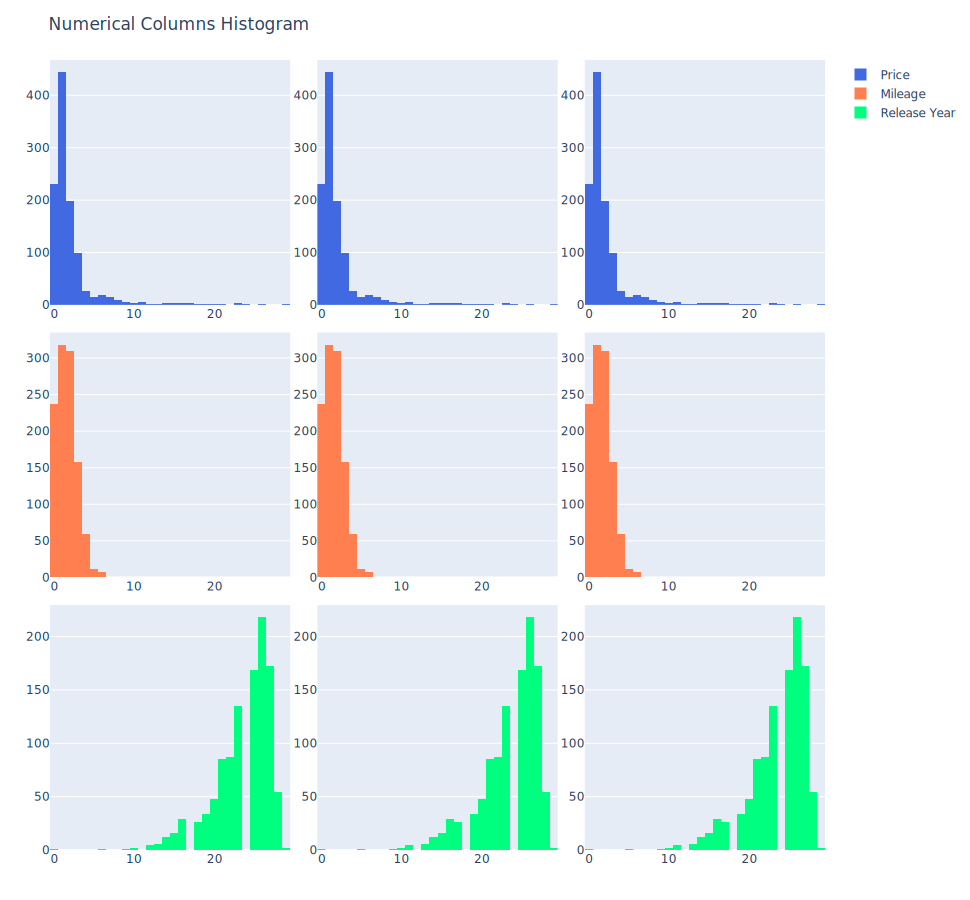

In [31]:
fig = make_subplots(rows=3, cols=3, vertical_spacing=0.035, horizontal_spacing=0.035)

fig.append_trace(go.Histogram(x=pd.cut(df_knn_fill_norm['car_price'].to_numpy().squeeze(), 30, labels=False), name='Price', marker_color='royalblue'), row=1, col=1)
fig.append_trace(go.Histogram(x=pd.cut(df_knn_fill_std['car_price'].to_numpy().squeeze(), 30, labels=False), name='Price', marker_color='royalblue', showlegend=False), row=1, col=2)
fig.append_trace(go.Histogram(x=pd.cut(df_knn_fill_rob['car_price'].to_numpy().squeeze(), 30, labels=False), name='Price', marker_color='royalblue', showlegend=False), row=1, col=3)

fig.append_trace(go.Histogram(x=pd.cut(df_knn_fill_norm['car_km'].to_numpy().squeeze(), 30, labels=False), name='Mileage', marker_color='coral'), row=2, col=1)
fig.append_trace(go.Histogram(x=pd.cut(df_knn_fill_std['car_km'].to_numpy().squeeze(), 30, labels=False), name='Mileage', marker_color='coral', showlegend=False), row=2, col=2)
fig.append_trace(go.Histogram(x=pd.cut(df_knn_fill_rob['car_km'].to_numpy().squeeze(), 30, labels=False), name='Price', marker_color='coral', showlegend=False), row=2, col=3)

fig.append_trace(go.Histogram(x=pd.cut(df_knn_fill_norm['car_year'].to_numpy().squeeze(), 30, labels=False), name='Release Year', marker_color='springgreen'), row=3, col=1)
fig.append_trace(go.Histogram(x=pd.cut(df_knn_fill_std['car_year'].to_numpy().squeeze(), 30, labels=False), name='Release Year', marker_color='springgreen', showlegend=False), row=3, col=2)
fig.append_trace(go.Histogram(x=pd.cut(df_knn_fill_rob['car_year'].to_numpy().squeeze(), 30, labels=False), name='Price', marker_color='springgreen', showlegend=False), row=3, col=3)

fig.update_layout(
    height=900, width=970, title_text="Numerical Columns Histogram",
    margin=dict(l=50, r=50, t=60, b=50)
)
fig.show()

---

### Limpeza de Dados

<p align="justify">
Essa seção se concentra na limpeza de dados possivelmente errados ou inconsistentes. Isso envolve a remoção de outliers, que são valores que destoam muito do restante dos dados e podem prejudicar a análise. Para isso, avaliaremos uma serie de testes estatísticos e visualizações, como método de Tukey, razão de variaveis, envelope eliptico e isolation forest.

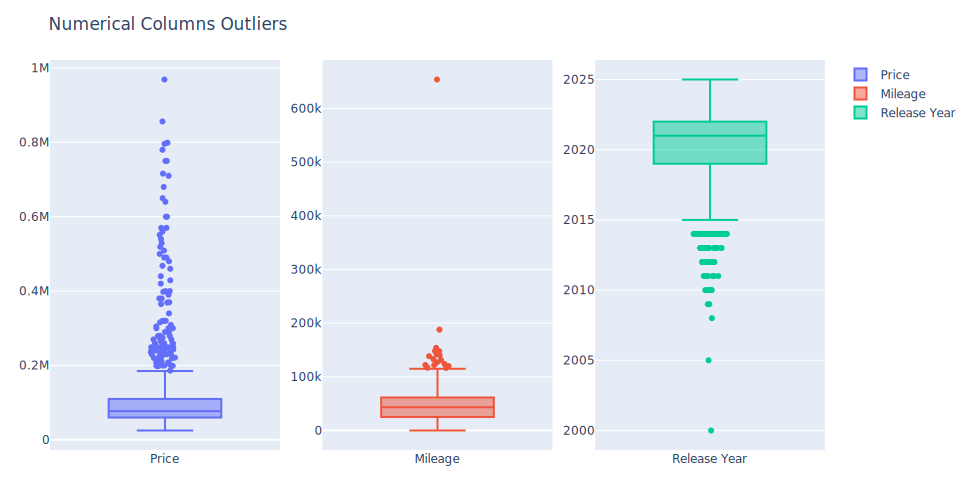

In [32]:
fig = make_subplots(rows=1, cols=3, vertical_spacing=0.035, horizontal_spacing=0.055)

fig.append_trace(go.Box(y=df_cars_codes['car_price'], name='Price', quartilemethod="linear"), row=1, col=1)
fig.append_trace(go.Box(y=df_cars_codes['car_km'], name='Mileage', quartilemethod="linear"), row=1, col=2)
fig.append_trace(go.Box(y=df_cars_codes['car_year'], name='Release Year', quartilemethod="linear"), row=1, col=3)

fig.update_traces(jitter=0.3)  # boxpoints='all'
fig.update_layout(
    height=500, width=970, title_text="Numerical Columns Outliers",
    margin=dict(l=50, r=50, t=60, b=50)
)

#### Método de Tukey (univariado)

<p align="justify">
O método de Tukey, também conhecido como Teste de Tukey ou Boxplot de Tukey, é uma técnica estatística amplamente utilizada para identificar outliers em conjuntos de dados univariados. Este método se baseia na análise dos quartis de um conjunto de dados e utiliza o intervalo interquartil (IQR) para definir outliers.

Calcula o IQR para cada coluna

In [33]:
q1 = df_cars_codes.quantile(q=0.25)
q3 = df_cars_codes.quantile(q=0.75)
iqr = q3 - q1
iqr

car_brand         18.0
car_name          59.0
car_price      50000.0
car_km         36391.5
car_year           3.0
car_engine        12.0
car_gearbox        1.0
car_fuel           0.0
dtype: float64

Remove outliers com base no preço e kilometragem do carro

In [34]:
df_cars_tukey = df_cars_codes[(df_cars_codes['car_price'] > (q1['car_price']-1.5*iqr['car_price'])) & (df_cars_codes['car_price'] < (q3['car_price']+1.5*iqr['car_price']))]
df_cars_tukey = df_cars_tukey[(df_cars_tukey['car_km'] > (q1['car_km']-1.5*iqr['car_km'])) & (df_cars_tukey['car_km'] < (q3['car_km']+1.5*iqr['car_km']))]
len(df_cars_tukey)

981

In [35]:
df_cars_tukey.head()

,car_brand,car_name,car_price,car_km,car_year,car_engine,car_gearbox,car_fuel
0,8,9,125990.0,7521.0,2022,29,0,1.0
1,1,108,128980.0,40000.0,2018,6,0,2.0
2,6,96,70990.0,40686.0,2023,0,1,2.0
3,6,96,79990.0,57643.0,2022,1,0,2.0
4,29,122,77990.0,29000.0,2023,10,1,2.0


#### Razão de Duas Variáveis (bivariado)

<p align="justify">
O método da Razão de Duas Variáveis é uma técnica simples e intuitiva para identificar outliers em conjuntos de dados bivariados. Esse método se baseia, intuitivamente, na razão entre duas variáveis para detectar valores que se desviam significativamente do padrão esperado.

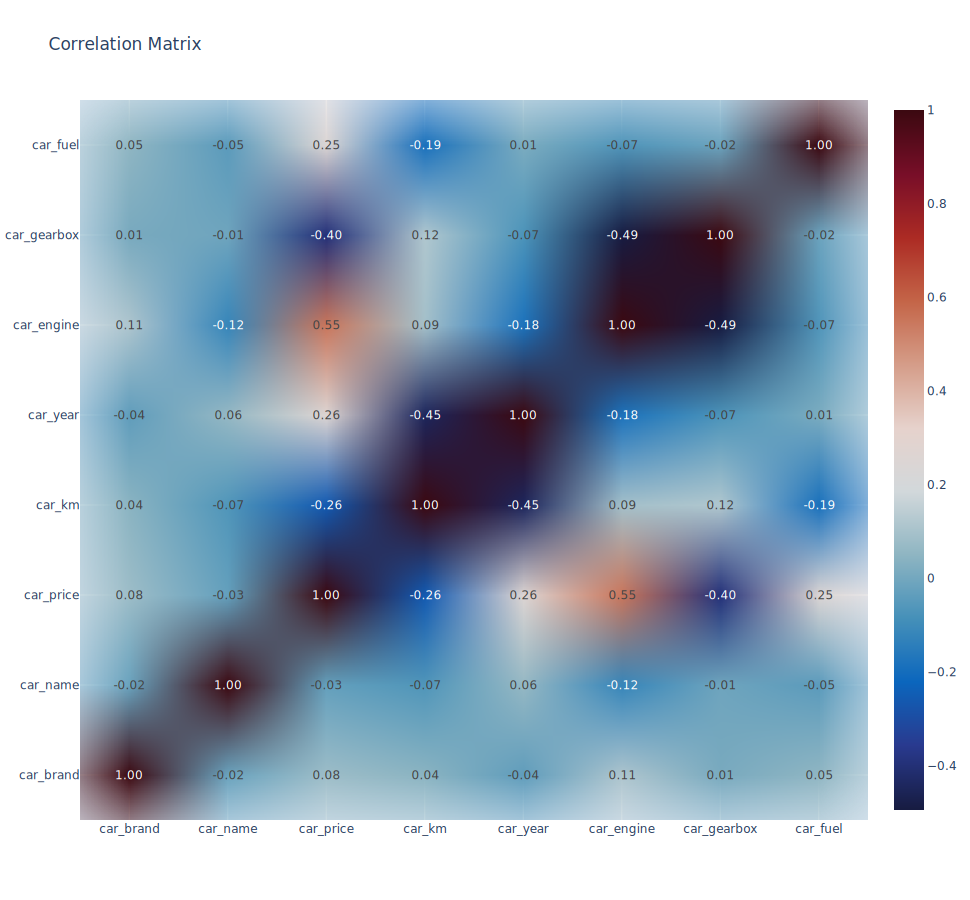

In [36]:
df_corr = df_cars_codes.corr()

fig = go.Figure(
    go.Heatmap(
        x = df_corr.columns,
        y = df_corr.index,
        z = np.array(df_corr),
        text=df_corr.values,
        texttemplate='%{text:.2f}',
        colorscale='balance'  # bluered
    )
)

fig.update_layout(height=900, width=970, title_text="Correlation Matrix")
fig.show()

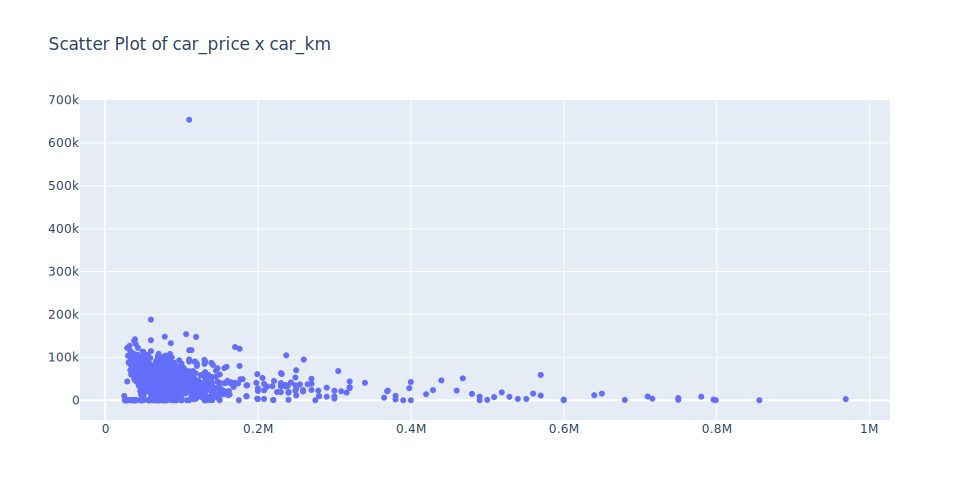

In [37]:
# df_cars.plot.scatter(x='car_price',y='car_km')
fig = go.Figure(
    go.Scatter(
        x=df_cars_codes['car_price'],
        y=df_cars_codes['car_km'],
        mode='markers',
    )
)

fig.update_layout(height=500, width=970, title_text="Scatter Plot of car_price x car_km")
fig.show()

In [38]:
df_cars_2_var = df_cars_codes.copy()
df_cars_2_var['car_price_per_km'] = df_cars_2_var['car_price'] / df_cars_2_var['car_km']
df_cars_2_var.head()

,car_brand,car_name,car_price,car_km,car_year,car_engine,car_gearbox,car_fuel,car_price_per_km
0,8,9,125990.0,7521.0,2022,29,0,1.0,16.751762
1,1,108,128980.0,40000.0,2018,6,0,2.0,3.224500
2,6,96,70990.0,40686.0,2023,0,1,2.0,1.744826
3,6,96,79990.0,57643.0,2022,1,0,2.0,1.387679
4,29,122,77990.0,29000.0,2023,10,1,2.0,2.689310


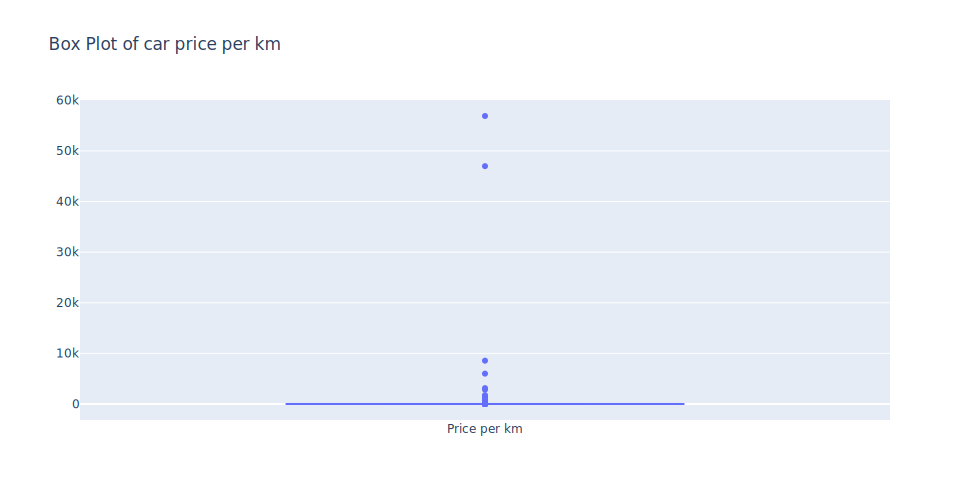

In [39]:
fig = go.Figure(
    go.Box(y=df_cars_2_var['car_price_per_km'], name='Price per km', quartilemethod="linear")
)

fig.update_layout(height=500, width=970, title_text="Box Plot of car price per km")
fig.show()

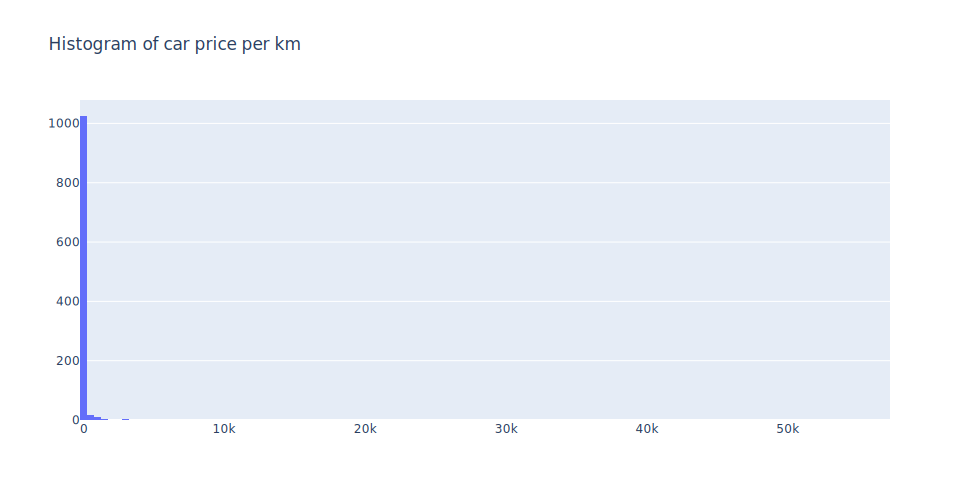

In [40]:
fig = go.Figure(
    go.Histogram(x=df_cars_2_var['car_price_per_km'], name='Price per km')
)

fig.update_layout(height=500, width=970, title_text="Histogram of car price per km")
fig.show()


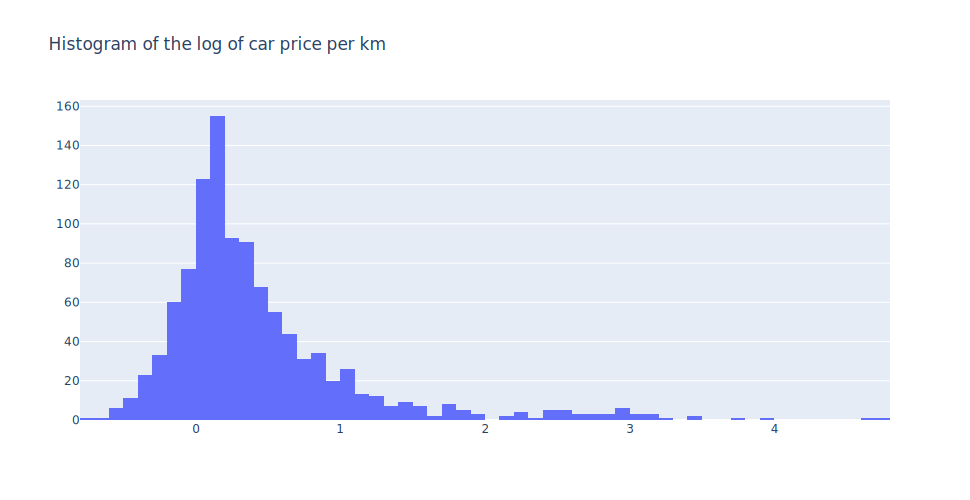

In [41]:
df_cars_2_var['car_price_per_km_log'] = np.log10(df_cars_2_var['car_price_per_km'])

fig = go.Figure(
    go.Histogram(x=df_cars_2_var['car_price_per_km_log'], name='Log of price per km')
)

fig.update_layout(height=500, width=970, title_text="Histogram of the log of car price per km")
fig.show()

In [42]:
mad = abs(df_cars_2_var['car_price_per_km_log'] - df_cars_2_var['car_price_per_km_log'].median()).median()*(1/0.6745)
print(mad)

0.3994815643854331


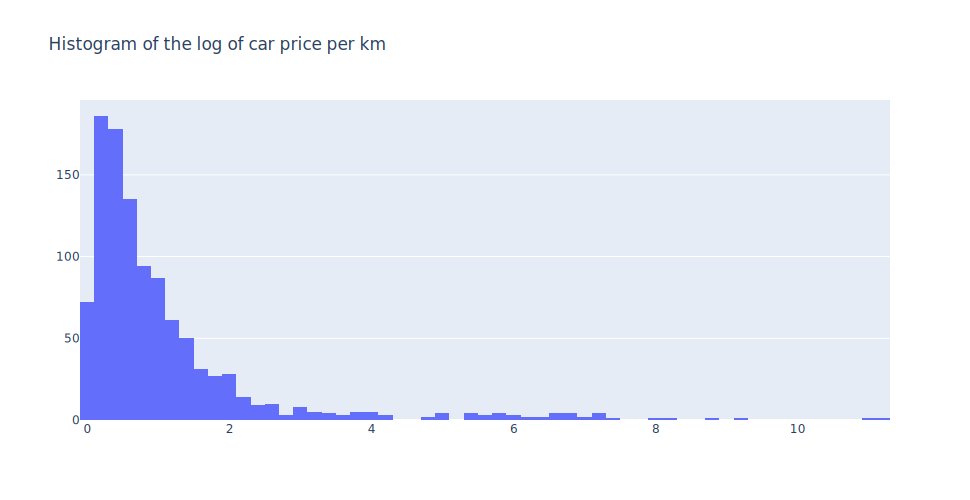

In [43]:
fig = go.Figure(
    go.Histogram(x=abs(df_cars_2_var['car_price_per_km_log']-df_cars_2_var['car_price_per_km_log'].median())/mad, name='Log of price per km')
)

fig.update_layout(height=500, width=970, title_text="Histogram of the log of car price per km")
fig.show()

In [44]:
len(df_cars_2_var[abs(df_cars_2_var['car_price_per_km_log']-df_cars_2_var['car_price_per_km_log'].median())/mad > 3.5])

101

In [45]:
df_cars_2_var = df_cars_2_var[abs(df_cars_2_var['car_price_per_km_log']-df_cars_2_var['car_price_per_km_log'].median())/mad < 3.5]
len(df_cars_2_var)

1002

#### Elliptic Envelope (multivariado)

<p align="justify">
O Elliptic Envelope é um método estatístico usado para identificar e lidar com outliers em um dataset, baseando-se na suposição de que os dados seguem uma distribuição elíptica (normal multivariada). Este método é particularmente útil em contextos onde os dados podem ser aproximadamente modelados por uma distribuição gaussiana. Em Python, o Elliptic Envelope pode ser facilmente implementado usando a biblioteca scikit-learn.

In [46]:
df_median_fill_ee = df_median_fill.copy()
df_median_fill_ee.count()

car_brand      1103
car_name       1103
car_price      1103
car_km         1103
car_year       1103
car_engine     1103
car_gearbox    1103
car_fuel       1103
dtype: int64

In [47]:
detector = EllipticEnvelope(contamination=0.01)
detector.fit(df_median_fill_ee)

EllipticEnvelope(contamination=0.01)

In [48]:
scores = detector.predict(df_median_fill_ee)
df_median_fill_ee['outlier'] = scores

df_median_fill_ee['outlier'] = df_median_fill_ee['outlier'].astype('int32')

df_median_fill_ee.head()


,car_brand,car_name,car_price,car_km,car_year,car_engine,car_gearbox,car_fuel,outlier
0,8,9,125990.0,7521.0,2022,29,0,1.0,1
1,1,108,128980.0,40000.0,2018,6,0,2.0,1
2,6,96,70990.0,40686.0,2023,0,1,2.0,1
3,6,96,79990.0,57643.0,2022,1,0,2.0,1
4,29,122,77990.0,29000.0,2023,10,1,2.0,1


In [49]:
df_median_fill_ee = df_median_fill_ee[(df_median_fill_ee['outlier'] != -1)]
df_median_fill_ee.head()

,car_brand,car_name,car_price,car_km,car_year,car_engine,car_gearbox,car_fuel,outlier
0,8,9,125990.0,7521.0,2022,29,0,1.0,1
1,1,108,128980.0,40000.0,2018,6,0,2.0,1
2,6,96,70990.0,40686.0,2023,0,1,2.0,1
3,6,96,79990.0,57643.0,2022,1,0,2.0,1
4,29,122,77990.0,29000.0,2023,10,1,2.0,1


In [50]:
df_median_fill_ee.count()

car_brand      1091
car_name       1091
car_price      1091
car_km         1091
car_year       1091
car_engine     1091
car_gearbox    1091
car_fuel       1091
outlier        1091
dtype: int64

#### Isolation Forests (multivariado)

<p align="justify">
Isolation Forest é um método baseado em árvores de decisão que é particularmente eficaz para a detecção de outliers. Ao contrário de outros métodos que modelam a distribuição dos dados, o Isolation Forest se baseia na ideia de que os outliers são pontos que são mais fáceis de isolar em um espaço de características. Assim como o método anterior, o Isolation Forest pode ser facilmente implementado em Python usando a biblioteca scikit-learn.

In [51]:
df_median_fill_if = df_median_fill.copy()
df_median_fill_if.count()

car_brand      1103
car_name       1103
car_price      1103
car_km         1103
car_year       1103
car_engine     1103
car_gearbox    1103
car_fuel       1103
dtype: int64

In [52]:
clf = IsolationForest(max_samples=100, random_state=np.random.RandomState(42))
clf.fit(df_median_fill_if)

scores = clf.predict(df_median_fill_if)
df_median_fill_if['outlier'] = scores

df_median_fill_if.head()

,car_brand,car_name,car_price,car_km,car_year,car_engine,car_gearbox,car_fuel,outlier
0,8,9,125990.0,7521.0,2022,29,0,1.0,-1
1,1,108,128980.0,40000.0,2018,6,0,2.0,1
2,6,96,70990.0,40686.0,2023,0,1,2.0,1
3,6,96,79990.0,57643.0,2022,1,0,2.0,1
4,29,122,77990.0,29000.0,2023,10,1,2.0,1


In [53]:
df_median_fill_if = df_median_fill_if[df_median_fill_if['outlier'] != -1]
df_median_fill_if.head()

,car_brand,car_name,car_price,car_km,car_year,car_engine,car_gearbox,car_fuel,outlier
1,1,108,128980.0,40000.0,2018,6,0,2.0,1
2,6,96,70990.0,40686.0,2023,0,1,2.0,1
3,6,96,79990.0,57643.0,2022,1,0,2.0,1
4,29,122,77990.0,29000.0,2023,10,1,2.0,1
5,13,33,117990.0,63379.0,2022,5,0,2.0,1


In [54]:
df_median_fill_if.count()

car_brand      819
car_name       819
car_price      819
car_km         819
car_year       819
car_engine     819
car_gearbox    819
car_fuel       819
outlier        819
dtype: int64

---

## Estatísticas Descritivas

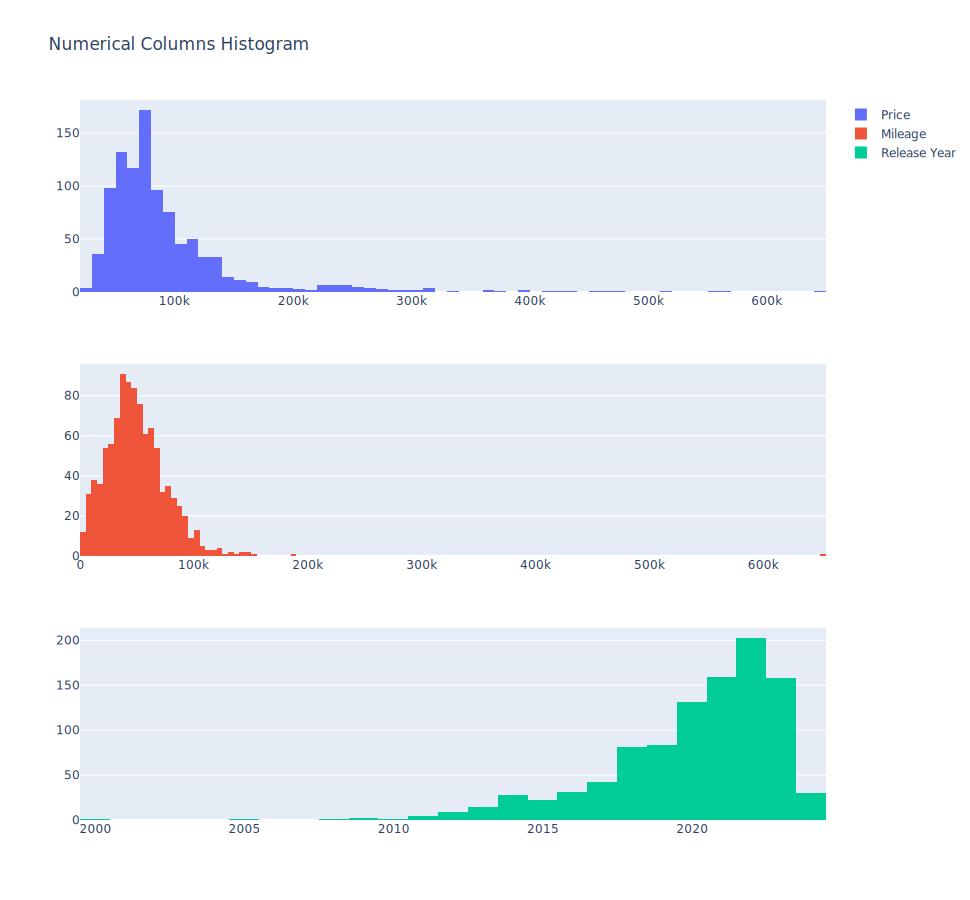

In [55]:
fig = make_subplots(rows=3, cols=1)

fig.append_trace(go.Histogram(x=df_cars_2_var['car_price'], name='Price'), row=1, col=1)
fig.append_trace(go.Histogram(x=df_cars_2_var['car_km'], name='Mileage'), row=2, col=1)
fig.append_trace(go.Histogram(x=df_cars_2_var['car_year'], name='Release Year'), row=3, col=1)

fig.update_layout(height=900, width=970, title_text="Numerical Columns Histogram")
fig.show()

Mostrar histograma dos motores (utilizando dataframe antes de utilizar cat codes)

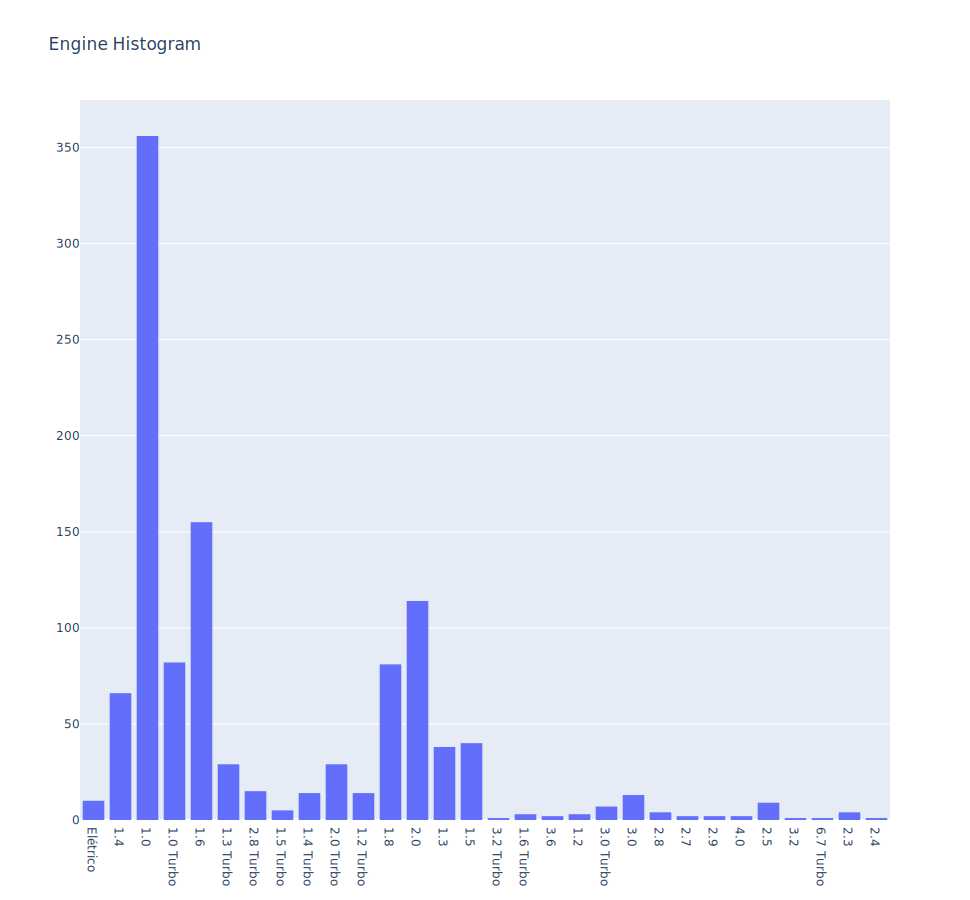

In [56]:
fig = go.Figure()

fig.add_trace(
    go.Histogram(x=df_cars_cat['car_engine'])
)

fig.update_layout(height=900, width=970, title_text="Engine Histogram")
fig.show()

---

## Teste de Hipóteses

<p align="justify">
Será feito um teste de hipótese para verificar se o preço dos carros a Diesel possuem um preço maior que a média.
Com isso, teremos as seguintes hipóteses:

> Hipótese nula: Carros a Diesel não possuem preço maior que a média

> Hipótese alternativa: Carros a Diesel possuem preço maior que a média

O teste utilizado será escolhido de acordo com a distribuição desses casos.

In [60]:
# Utilizando cat codes, o valor para 'Diesel' é 0
df_diesel_above_avg_cars = df_median_fill[(df_median_fill['car_fuel']==0) & (df_median_fill['car_price'] > df_median_fill['car_price'].mean())]
df_diesel_below_avg_cars = df_median_fill[(df_median_fill['car_fuel']==0) & (df_median_fill['car_price'] <= df_median_fill['car_price'].mean())]

alpha = 0.05
shapiro_above_avg = shapiro(df_diesel_above_avg_cars)
shapiro_below_avg = shapiro(df_diesel_below_avg_cars)

In [62]:
if shapiro_above_avg.pvalue > alpha and shapiro_below_avg.pvalue > alpha: #Se segue uma normal, realiza um ttest
    print("Teste escolhido: t test")
    p_value = ttest_rel(df_diesel_above_avg_cars, df_diesel_below_avg_cars).pvalue
else: #Se não utiliza o teste Mann-Whitney
    print("Teste escolhido: Mann-Whitney")
    p_value = mannwhitneyu(df_diesel_above_avg_cars, df_diesel_below_avg_cars).pvalue

if p_value[2] < alpha:  #O valor de p_value escolhido foi o terceiro (correspondente a coluna de preço)
    print(f"p_value: {p_value[2]}")
    print("A hipótese nula foi rejeitada")
else:
    print(f"p_value: {p_value[2]}")
    print("A hipótese nula foi aceita")

Teste escolhido: Mann-Whitney
p_value: 7.92659861603947e-08
A hipótese nula foi rejeitada


Com isso, foi possível observar que a hipótese nula foi rejeitada. Ou seja, os carros a Diesel possuem preço acima da média em comparação aos outros carros.

---

## Referências

- https://plotly.com/python/histograms/
- https://plotly.com/python/legend/
- https://plotly.com/python/builtin-colorscales/